# APA Laboratori 0 - Data preprocessing

In [1]:
# Uncomment to upgrade packages
# !pip install pandas --upgrade 
# !pip install numpy --upgrade
# !pip install scipy --upgrade
# !pip install statsmodels --upgrade
%load_ext autoreload

<div class="alert alert-block alert-info">

**INSTRUCCIONS**

No cal entregar res, cal assimilar

S'ha de fer amb calma, sense córrer, mirant d'entendre en tot moment què s'està fent **a nivell conceptual** i quin efecte té

 Podeu deixar el codi python en si (crides, paràmetres, sintaxi) per una segona lectura o com a treball personal. El codi python és un mitjà, no un objectiu.
 
</div>

In [2]:
#%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('precision', 3)

In [3]:
# extra imports
from pandas import read_csv
from sklearn.neighbors import KNeighborsClassifier
from statsmodels.genmod.generalized_linear_model import GLM
from pandas.plotting import scatter_matrix
from scipy.stats import boxcox

## SECTION 1: READING THE FILE CREDSCO.TXT (loan data: credit scoring)

 Reading properly a data set is non-trivial because you need to know
 its data format: decimal separator, column separator, is there a
 header? how are strings quoted? how (if any) are missing values
 coded? should character vectors be converted to factors? should
 white spaces be stripped?, ...)

 It is a good idea to consult  [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html)  and play with useful control parameters.
 
 after opening the file `credsco.csv` and inspecting it, we decide the following settings:

In [4]:
Credit = read_csv("credsco.csv", header=0, delimiter=',')
Credit.shape

(4455, 14)

 Basic questions:

* Which is the target variable? where is it? how many different values? is it a classification problem or a regression problem?

* *answers:* the target variable is located in column 1 and is called 'Assessment'; it has two possible values (therfore it is a classification problem)

What are the other variables?

In [5]:
Credit.columns

Index(['Assessment', 'YearsInJob', 'Housing', 'Deadline', 'Age',
       'MaritalStatus', 'Records', 'TypeOfJob', 'Expenses', 'Income',
       'Capital', 'ChargesOnCapital', 'AmountRequested', 'MarketPrice'],
      dtype='object')

 You can consult the file "Credsco-traduccions.txt" for translation into Catalan

inspect the first 4 examples

In [6]:
Credit[:4]

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325


inspect predictive variables 4, 5, 6 and 7 for the first example

In [7]:
Credit.iloc[0,4:8]

Age              30
MaritalStatus     2
Records           1
TypeOfJob         3
Name: 0, dtype: int64

Alternatively you can use the variable names

In [8]:
Credit.loc[0,'Age':'TypeOfJob']

Age              30
MaritalStatus     2
Records           1
TypeOfJob         3
Name: 0, dtype: int64

***
## SECTION 2: BASIC INSPECTION OF THE DATASET

Perform a basic inspection of the dataset. Have a look at the minimum and maximum values for each variable; find possible errors and abnormal values (outliers); find possible missing values; decide which variables are continuous and which are categorical; if there are mixed types, we have three options: recode continuous to categorical, recode categorical to continuous or leave them as they are. In the latter case, either the method accepts both kinds of information, or it does not, in which case python will convert the categorical ones to continuous using a dummy code.

In [9]:
Credit.describe()

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
count,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4455.000,4.455e+03,4.455e+03,4.455e+03,4455.000,4455.000
mean,1.281,7.987,2.657,46.442,37.078,1.879,1.174,1.676,55.569,7.633e+05,1.060e+06,4.044e+05,1039.022,1462.876
std,0.450,8.173,1.610,14.655,10.985,0.644,0.379,0.954,19.516,8.704e+06,1.022e+07,6.344e+06,474.543,628.090
min,0.000,0.000,0.000,6.000,18.000,0.000,1.000,0.000,35.000,0.000e+00,0.000e+00,0.000e+00,100.000,105.000
25%,1.000,2.000,2.000,36.000,28.000,2.000,1.000,1.000,35.000,8.000e+01,0.000e+00,0.000e+00,700.000,1117.500
50%,1.000,5.000,2.000,48.000,36.000,2.000,1.000,1.000,51.000,1.200e+02,3.500e+03,0.000e+00,1000.000,1400.000
75%,2.000,12.000,4.000,60.000,45.000,2.000,1.000,3.000,72.000,1.660e+02,6.000e+03,0.000e+00,1300.000,1692.000
max,2.000,48.000,6.000,72.000,68.000,5.000,2.000,4.000,180.000,1.000e+08,1.000e+08,1.000e+08,5000.000,11140.000


 Assessment,Housing,MaritalStatus,Records,TypeOfJob are categorical and need to be treated properly

 In particular, Assessment is the target variable; we need to identify correct values

 Capital, ChargesOnCapital and Income present abnormally high maximums (99999999)

 There are also suspicious zeros, in both types of variables, which we identify with missing values

## SECTION 3: DEALING WITH MISSING VALUES

Sometimes we need to take a decision on a sensible treatment for the missing values and apply it; it is wise to write down the possible consequences of this decision and the alternatives that could be considered in case the final results are not satisfactory

the easiest way is of course to eliminate the involved rows or
columns; this can be done partially. For example, we could decide to
eliminate the variables with the highest proportion of missing values.

Deleting instances and/or variables containing missing values results
in loss of relevant data and is also frustrating because of the effort
in collecting the sacrificed information.

<div class="alert alert-block alert-warning">
CAREFUL! python does not know magically which entries are missing values: they have to be explicitly declared as NA's
</div>

therefore this code is not useful:

In [10]:
Credit_complete = Credit.dropna()
Credit_complete.shape

(4455, 14)

 the previous code does nothing! (but it seems it does)

 In the present case we have decided to perform a step-by-step treatment, separate for the categorical and continuous information

 We first decide to remove those rows with with missing values in the categorical variables (there are few)

In [11]:
(Credit.Assessment==0).value_counts()
(Credit.Housing==0).value_counts()
(Credit.MaritalStatus==0).value_counts()
(Credit.TypeOfJob==0).value_counts()

False    4454
True        1
Name: Assessment, dtype: int64

False    4449
True        6
Name: Housing, dtype: int64

False    4454
True        1
Name: MaritalStatus, dtype: int64

False    4453
True        2
Name: TypeOfJob, dtype: int64

In [12]:
Credit=  Credit[(Credit.Assessment!=0) & (Credit.Housing!=0)
                &(Credit.MaritalStatus!=0)&(Credit.TypeOfJob!=0)]
Credit.shape

(4446, 14)

 Process rows with missing values in the continuous variables (code 99999999)

 look at that:

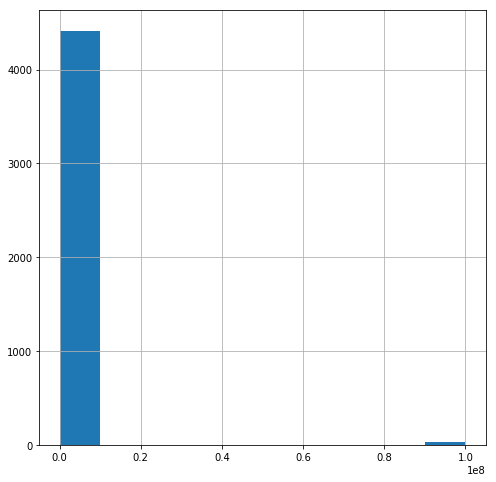

In [13]:
Credit.Income.hist(figsize=(8,8));

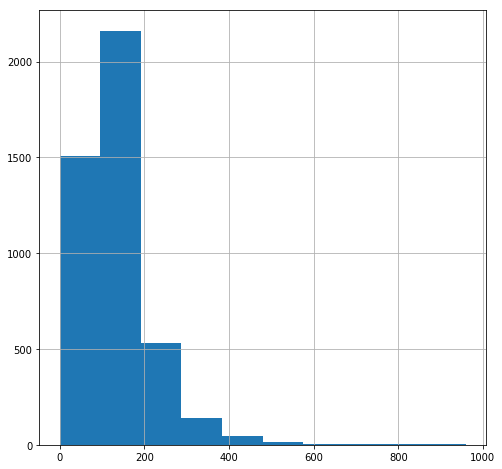

In [14]:
Credit.Income[Credit.Income!=99999999].hist(figsize=(8,8));

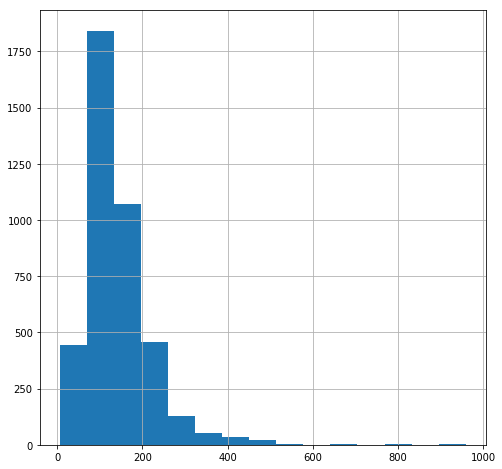

In [15]:
Credit.Income[(Credit.Income!=99999999)&
              (Credit.Income!=0)].hist(bins=15,figsize=(8,8));

 these are then clearly incorrect

In [16]:
(Credit.Income==99999999).value_counts()
(Credit.Income==0).value_counts()
(Credit.Capital==99999999).value_counts()
(Credit.ChargesOnCapital==99999999).value_counts()

False    4415
True       31
Name: Income, dtype: int64

False    4100
True      346
Name: Income, dtype: int64

False    4405
True       41
Name: Capital, dtype: int64

False    4434
True       12
Name: ChargesOnCapital, dtype: int64

In [17]:
(Credit.Income==99999999).value_counts()

False    4415
True       31
Name: Income, dtype: int64

 what do we do with this one? let's assume it is correct

In [18]:
(Credit.YearsInJob==0).value_counts()

False    3914
True      532
Name: YearsInJob, dtype: int64

 Continuous variables have too many missing values, we can not eliminate them just like that: we must devise a treatment for these missing values

 first we mark them to 'NA', including those from no 'Income'

In [19]:
Credit.Income[(Credit.Income == 99999999) | (Credit.Income == 0)] = np.nan
Credit.Capital[Credit.Capital == 99999999]  = np.nan
Credit.ChargesOnCapital[Credit.ChargesOnCapital == 99999999]  = np.nan

see the difference?

In [20]:
Credit.Income.describe()

count    4069.000
mean      141.704
std        80.694
min         6.000
25%        90.000
50%       125.000
75%       170.000
max       959.000
Name: Income, dtype: float64

 The word 'imputation' refers to assigning a value to every missing value. Here we perform imputation by a method known as 1NN: for every individual with a missing 'Income', we look for the most similar individual (according to the remaining variables) and then copy its 'Income' value.
 
 As we can not have missing values in any column for computing the 1KNN we will make a classifier dropping the columns with missing values and training a classifier for each column
 

In [21]:
aux = Credit.drop(columns='Income')\
    .drop(columns='Capital')\
    .drop(columns='ChargesOnCapital')
aux.shape
aux1 = aux[Credit.Income.notna() & 
           Credit.Capital.notna() & 
           Credit.ChargesOnCapital.notna()]
aux1.shape
aux2 = aux[Credit.Income.isna()]
aux2.shape

(4446, 11)

(4039, 11)

(377, 11)

 Neither of aux1, aux2 can contain NAs

In [22]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(aux1, Credit.Income[Credit.Income.notna() &
                            Credit.Capital.notna() &
                            Credit.ChargesOnCapital.notna()])
knn_inc = knn.predict(aux2);

 Imputation of 'Capital'

In [23]:
aux2 = aux[Credit.Capital.isna()]

In [24]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(aux1, Credit.Capital[Credit.Income.notna()&
                             Credit.Capital.notna() & 
                             Credit.ChargesOnCapital.notna()])
knn_cap = knn.predict(aux2);


Imputation of 'ChargesOnCapital'

In [25]:
aux2 = aux[Credit.ChargesOnCapital.isna()]

In [26]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(aux1, Credit.ChargesOnCapital[Credit.Income.notna()&
                                      Credit.Capital.notna() &
                                      Credit.ChargesOnCapital.notna()])
knn_cop = knn.predict(aux2);

In [27]:
Credit.Income[Credit.Income.isna()] =knn_inc
Credit.Capital[Credit.Capital.isna()] =knn_cap
Credit.ChargesOnCapital[Credit.ChargesOnCapital.isna()] =knn_cop
Credit.ChargesOnCapital[Credit.Capital==0] = 0

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


There are other less computational expensive methods for missing value imputations such as replacing with mean, median or mode. All these can be computed using pandas `replace` and `fillna` functions, you can find more info [here](https://pandas.pydata.org/pandas-docs/stable/missing_data.html)

The Scikit-learn library has also a method for the most simple missing value imputation [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html)

inspect again the result, especially the new statistics

In [28]:
Credit.shape
Credit.describe()

(4446, 14)

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice
count,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000
mean,1.281,7.991,2.660,46.453,37.084,1.880,1.173,1.676,55.601,141.689,5383.702,343.312,1038.763,1462.480
std,0.450,8.176,1.609,14.648,10.986,0.643,0.378,0.954,19.521,80.082,11527.920,1245.731,474.748,628.555
min,1.000,0.000,1.000,6.000,18.000,1.000,1.000,1.000,35.000,6.000,0.000,0.000,100.000,105.000
25%,1.000,2.000,2.000,36.000,28.000,2.000,1.000,1.000,35.000,90.000,0.000,0.000,700.000,1116.250
50%,1.000,5.000,2.000,48.000,36.000,2.000,1.000,1.000,51.000,125.000,3000.000,0.000,1000.000,1400.000
75%,2.000,12.000,4.000,60.000,45.000,2.000,1.000,3.000,72.000,171.000,6000.000,0.000,1300.000,1691.500
max,2.000,48.000,6.000,72.000,68.000,5.000,2.000,4.000,180.000,959.000,300000.000,30000.000,5000.000,11140.000


***
## SECTION 4: TREATMENT OF MIXED DATA TYPES


 In this case we have decided to keep the original type and leave the decision for later, depending on the specific analysis

 we explicitly declare categorical variables as such 

In [29]:
Credit.dtypes

Assessment            int64
YearsInJob            int64
Housing               int64
Deadline              int64
Age                   int64
MaritalStatus         int64
Records               int64
TypeOfJob             int64
Expenses              int64
Income              float64
Capital             float64
ChargesOnCapital    float64
AmountRequested       int64
MarketPrice           int64
dtype: object

In [30]:
# There is a categorical datatype in pandas, but for most things this will do
Credit.Assessment = Credit.Assessment.astype('object')
Credit.Housing = Credit.Housing.astype('object')
Credit.MaritalStatus = Credit.MaritalStatus.astype('object')
Credit.Records = Credit.Records.astype('object')
Credit.TypeOfJob = Credit.TypeOfJob.astype('object')

Credit.Assessment.unique()
Credit.Housing .unique()
Credit.MaritalStatus.unique()
Credit.Records.unique()
Credit.TypeOfJob.unique()


array([1, 2], dtype=object)

array([1, 2, 5, 3, 6, 4], dtype=object)

array([2, 3, 1, 4, 5], dtype=object)

array([1, 2], dtype=object)

array([3, 1, 2, 4], dtype=object)

not very nice, right? let's recode

In [31]:
Credit.Assessment.replace([1, 2], 
                          ["positive","negative"], 
                          inplace=True)
Credit.Housing.replace([1,2,3,4,5,6], 
                       ["rent","owner","private","ignore","parents","other"], 
                       inplace=True)
Credit.MaritalStatus.replace([1,2,3,4,5], 
                             ["single","married","widower","split","divorced"], 
                             inplace=True)
Credit.Records.replace([1, 2], 
                       ["no","yes"], inplace=True)
Credit.TypeOfJob.replace([1,2,3,4], 
                         ["indefinite","temporal","self-employed","other"], 
                         inplace=True)


***
## SECTION 5: DERIVATION OF NEW VARIABLES: FEATURE EXTRACTION

 We decide whether it can be sensible to derive new variables; we extract two new continuous and one new categorical variable (for the sake of illustration):

 Financing ratio (continuous)


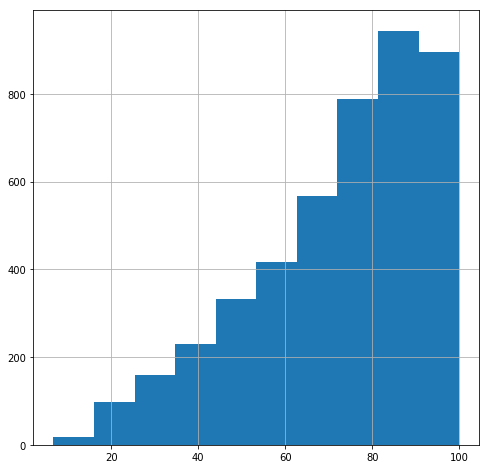

In [32]:
Credit['FinancingRatio'] = 100*Credit.AmountRequested/Credit.MarketPrice
Credit.FinancingRatio.hist(figsize=(8,8));

 Saving capacity (continuous)

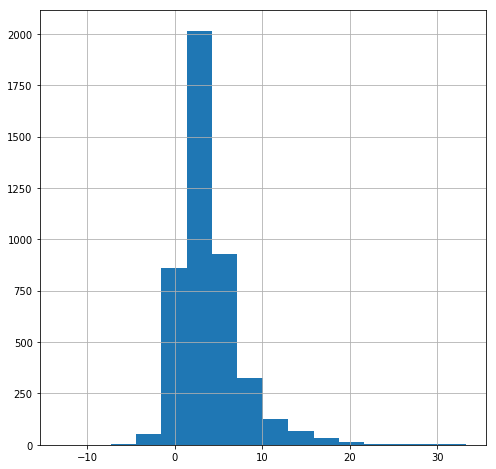

In [33]:
Credit['SavingCapacity'] = (Credit.Income- Credit.Expenses-(Credit.ChargesOnCapital/100))\
                            /(Credit.AmountRequested/Credit.Deadline)
Credit.SavingCapacity.hist(bins=16,figsize=(8,8));

 Amount Requested greater than the median by people younger than 1.25 times the mean (categorical):

In [34]:
Credit['Dubious'] = ['No']*Credit.shape[0]
Credit.Dubious[(Credit.AmountRequested > Credit.AmountRequested.median(skipna=True)) &
               (Credit.Age < 1.25*Credit.Age.mean(skipna=True))] = "Yes"
pd.crosstab(Credit.Dubious, Credit.Assessment)

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Assessment,negative,positive
Dubious,,
No,668,2200
Yes,581,997


***
## SECTION 6: WHAT WE HAVE DONE SO FAR


 Create a new dataframe that gathers everything and inspect it again

In [35]:
Credit_new =Credit.copy()
                   
Credit_new.describe(include='all')
Credit_new.shape

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,Capital,ChargesOnCapital,AmountRequested,MarketPrice,FinancingRatio,SavingCapacity,Dubious
count,4446,4446.000,4446,4446.000,4446.000,4446,4446,4446,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446.000,4446
unique,2,NaN,6,NaN,NaN,5,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,positive,NaN,owner,NaN,NaN,married,no,indefinite,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
freq,3197,NaN,2106,NaN,NaN,3238,3677,2803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2868
mean,NaN,7.991,NaN,46.453,37.084,NaN,NaN,NaN,55.601,141.689,5383.702,343.312,1038.763,1462.480,72.616,3.911,NaN
std,NaN,8.176,NaN,14.648,10.986,NaN,NaN,NaN,19.521,80.082,11527.920,1245.731,474.748,628.555,20.391,3.738,NaN
min,NaN,0.000,NaN,6.000,18.000,NaN,NaN,NaN,35.000,6.000,0.000,0.000,100.000,105.000,6.702,-13.104,NaN
25%,NaN,2.000,NaN,36.000,28.000,NaN,NaN,NaN,35.000,90.000,0.000,0.000,700.000,1116.250,60.030,1.680,NaN
50%,NaN,5.000,NaN,48.000,36.000,NaN,NaN,NaN,51.000,125.000,3000.000,0.000,1000.000,1400.000,77.097,3.142,NaN
75%,NaN,12.000,NaN,60.000,45.000,NaN,NaN,NaN,72.000,171.000,6000.000,0.000,1300.000,1691.500,88.460,5.232,NaN


(4446, 17)

***
## SECTION 7: GAUSSIANITY AND TRANSFORMATIONS


 Perform a graphical summary of some of the variables (both categorical and continuous), using the boxplot() and hist() procedures

 For continuous data:
 histograms and boxplots

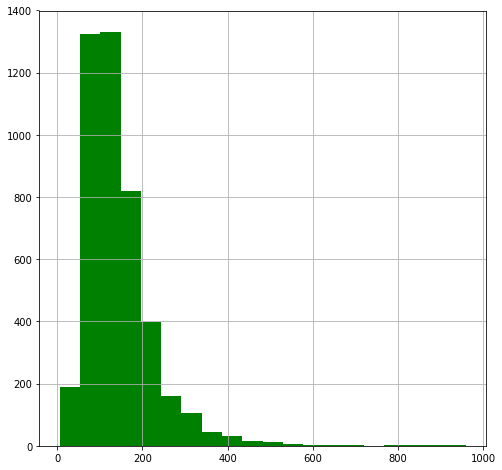

In [36]:
Credit_new.Income.hist(bins=20,figsize=(8,8), color='green');

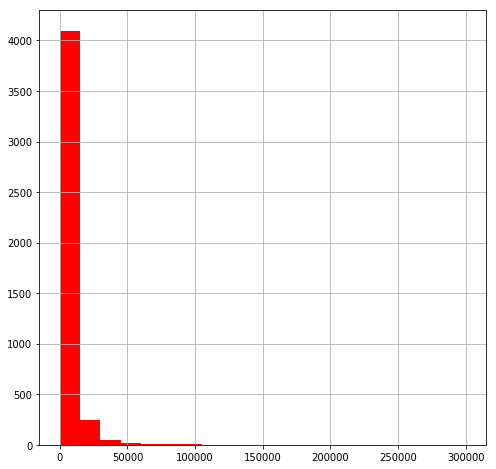

In [37]:
Credit_new.Capital.hist(bins=20,figsize=(8,8), color='red');

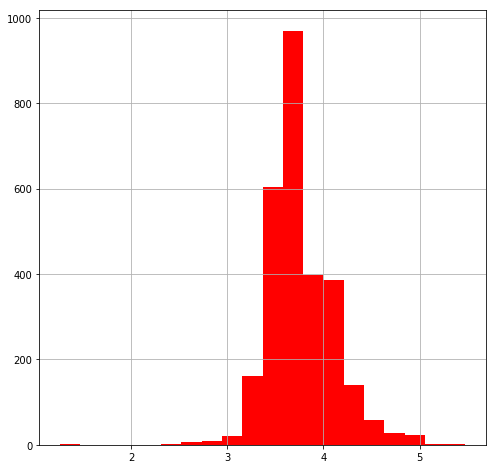

In [38]:
pd.options.mode.use_inf_as_na = True
Credit_new.Capital.apply(np.log10).hist(bins=20,figsize=(8,8), color='red');

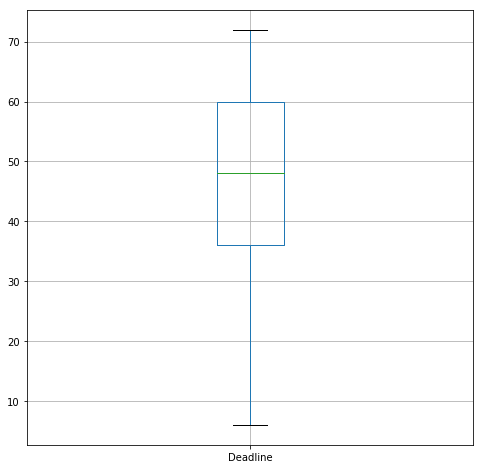

In [39]:
Credit_new.boxplot(column='Deadline',figsize=(8,8));

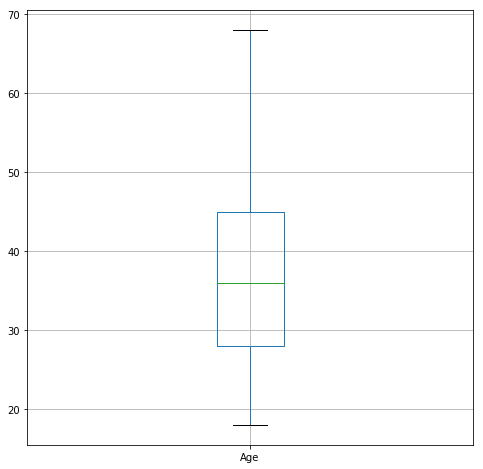

In [40]:
Credit_new.boxplot(column='Age',figsize=(8,8));

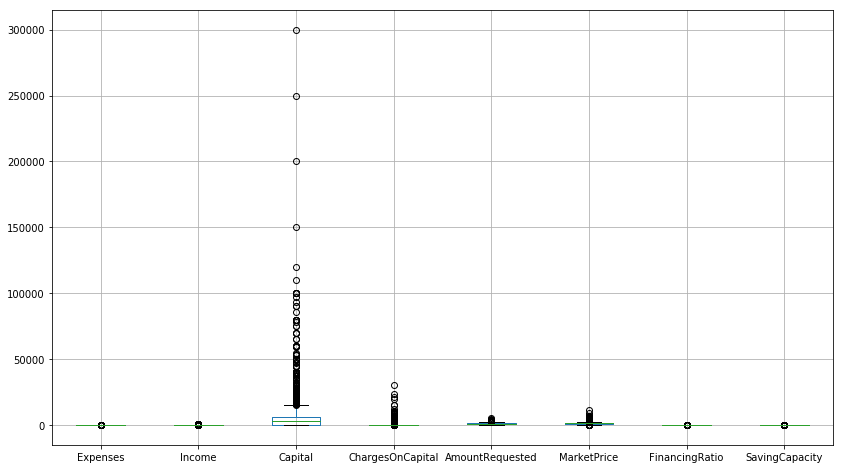

In [41]:
Credit_new.loc[:,"Expenses":"SavingCapacity"].boxplot(figsize=(14,8));

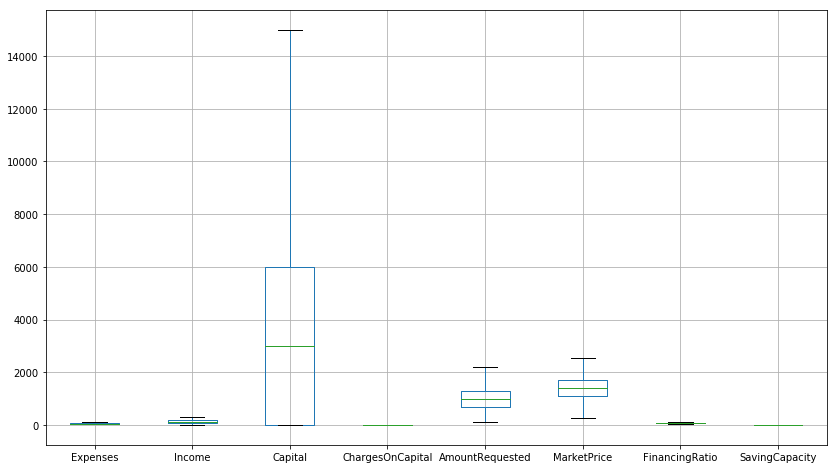

In [42]:
Credit_new.loc[:,"Expenses":"SavingCapacity"].boxplot(figsize=(14,8),showfliers=False); # much better, but would be nicer one by one

 the previous plots suggest to take logs on some variables: Capital and ChargesOnCapital (we'll do it later)

 For categorical data:
 Frequency tables, Contingency tables, Bar charts, Pie charts

 should we treat Age as categorical? probably not

In [43]:
Credit_new.Age.unique()

array([30, 58, 46, 24, 26, 36, 44, 27, 32, 41, 34, 29, 37, 21, 68, 52, 31,
       25, 22, 45, 51, 54, 43, 23, 39, 35, 62, 56, 64, 42, 61, 49, 47, 28,
       63, 55, 40, 53, 38, 57, 33, 66, 50, 48, 59, 60, 19, 65, 20, 18])

In [44]:
Credit_new.Age.min()
Credit_new.Age.max()

18

68

In [45]:
bins = pd.IntervalIndex.from_tuples([(0, 1), (2, 3), (4, 5)])
bins

IntervalIndex([(0, 1], (2, 3], (4, 5]]
              closed='right',
              dtype='interval[int64]')

In [46]:
pd.interval_range(start=30, end=90,freq=10)

IntervalIndex([(30, 40], (40, 50], (50, 60], (60, 70], (70, 80], (80, 90]]
              closed='right',
              dtype='interval[int64]')

In [47]:
pd.cut(Credit_new.Age,
       bins=pd.interval_range(start=30, end=90,freq=10))  
# WARNING! we are generating NAs               

0            NaN
1       (50, 60]
2       (40, 50]
3            NaN
4            NaN
5       (30, 40]
6       (40, 50]
7            NaN
8       (30, 40]
9       (40, 50]
10      (30, 40]
11           NaN
12           NaN
13      (30, 40]
14           NaN
15      (60, 70]
16      (50, 60]
17      (60, 70]
18      (30, 40]
19      (30, 40]
20           NaN
21           NaN
22      (40, 50]
23      (40, 50]
24      (50, 60]
25      (50, 60]
26      (40, 50]
27      (40, 50]
28           NaN
30           NaN
          ...   
4425    (40, 50]
4426         NaN
4427    (40, 50]
4428    (40, 50]
4429         NaN
4430    (30, 40]
4431    (60, 70]
4432    (30, 40]
4433    (30, 40]
4434    (50, 60]
4435    (30, 40]
4436         NaN
4437         NaN
4438    (30, 40]
4439    (30, 40]
4440    (30, 40]
4441    (40, 50]
4442    (30, 40]
4443    (30, 40]
4444    (30, 40]
4445         NaN
4446    (40, 50]
4447    (50, 60]
4448    (40, 50]
4449         NaN
4450    (30, 40]
4451    (40, 50]
4452    (30, 4

In [48]:
Age_cut = pd.cut(Credit_new.Age,
                 bins=pd.interval_range(start=15, end=75,freq=10)) ;

In [49]:
Credit_new['Age_cat'] = Age_cut.astype('str')

In [50]:
Credit_new.Age_cat.value_counts().sort_index()

(15, 25]     699
(25, 35]    1509
(35, 45]    1172
(45, 55]     773
(55, 65]     282
(65, 75]      11
Name: Age_cat, dtype: int64

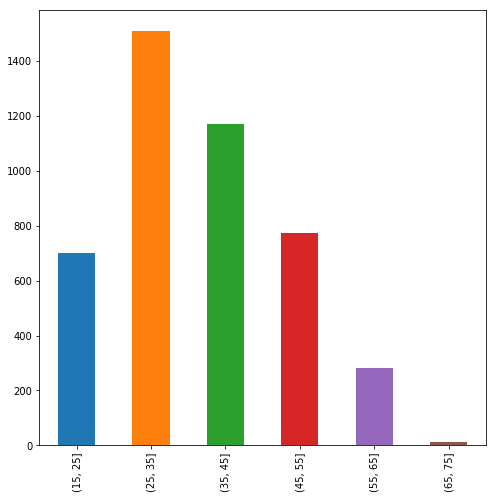

In [51]:
Credit_new.Age_cat.value_counts().sort_index().plot.bar(figsize=(8,8));

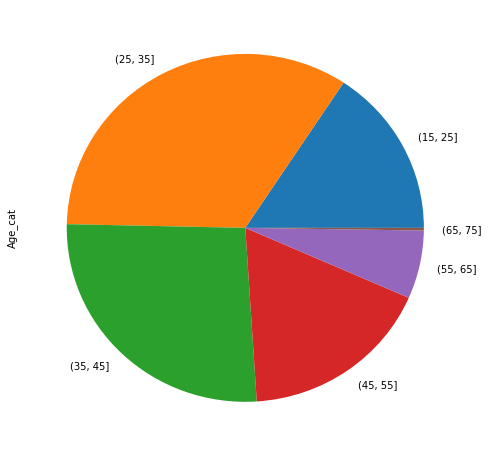

In [52]:
Credit_new.Age_cat.value_counts().sort_index().plot.pie(figsize=(8,8));

 incidentally, this is how we could generate another new variable based on Age:

In [53]:
Credit_new['Age2_cat'] = Credit_new.Age.apply(lambda x : 
                                              'under55' if x < 55 else 'over55')

In [54]:
TypeOfJob_Age= pd.crosstab(Credit_new.TypeOfJob, Credit_new.Age_cat)
TypeOfJob_Age

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,408,1054,742,463,132,4
other,17,28,30,30,61,5
self-employed,91,272,319,250,87,2
temporal,183,155,81,30,2,0


In [55]:
TypeOfJob_Age.sum(axis=0) # row sums
TypeOfJob_Age.sum(axis=1) # column sums

Age_cat
(15, 25]     699
(25, 35]    1509
(35, 45]    1172
(45, 55]     773
(55, 65]     282
(65, 75]      11
dtype: int64

TypeOfJob
indefinite       2803
other             171
self-employed    1021
temporal          451
dtype: int64

In [56]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize=True,
            margins=True) # relative frequencies

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,0.092,0.237,0.167,0.104,2.969e-02,8.997e-04,0.630
other,0.004,0.006,0.007,0.007,1.372e-02,1.125e-03,0.038
self-employed,0.020,0.061,0.072,0.056,1.957e-02,4.498e-04,0.230
temporal,0.041,0.035,0.018,0.007,4.498e-04,0.000e+00,0.101
All,0.157,0.339,0.264,0.174,6.343e-02,2.474e-03,1.000


In [57]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize=True,margins=True).round(decimals=3)
            # idem, rounded to 3 digits

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,0.092,0.237,0.167,0.104,0.030,0.001,0.630
other,0.004,0.006,0.007,0.007,0.014,0.001,0.038
self-employed,0.020,0.061,0.072,0.056,0.020,0.000,0.230
temporal,0.041,0.035,0.018,0.007,0.000,0.000,0.101
All,0.157,0.339,0.264,0.174,0.063,0.002,1.000


In [58]:
(pd.crosstab(Credit_new.TypeOfJob,
             Credit_new.Age_cat,
             normalize=True,
             margins=True)*100).round(decimals=3) 
             # total percentages

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]",All
TypeOfJob,,,,,,,
indefinite,9.177,23.707,16.689,10.414,2.969,0.090,63.045
other,0.382,0.630,0.675,0.675,1.372,0.112,3.846
self-employed,2.047,6.118,7.175,5.623,1.957,0.045,22.964
temporal,4.116,3.486,1.822,0.675,0.045,0.000,10.144
All,15.722,33.941,26.361,17.386,6.343,0.247,100.000


In [59]:
pd.crosstab(Credit_new.TypeOfJob,
            Credit_new.Age_cat,
            normalize="index").round(decimals=3) 
            # table of relative frequencies (column-wise)
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").round(decimals=3) 
            # table of relative frequencies (row-wise)

Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,0.146,0.376,0.265,0.165,0.047,0.001
other,0.099,0.164,0.175,0.175,0.357,0.029
self-employed,0.089,0.266,0.312,0.245,0.085,0.002
temporal,0.406,0.344,0.180,0.067,0.004,0.000


Age_cat,"(15, 25]","(25, 35]","(35, 45]","(45, 55]","(55, 65]","(65, 75]"
TypeOfJob,,,,,,
indefinite,0.584,0.698,0.633,0.599,0.468,0.364
other,0.024,0.019,0.026,0.039,0.216,0.455
self-employed,0.130,0.180,0.272,0.323,0.309,0.182
temporal,0.262,0.103,0.069,0.039,0.007,0.000


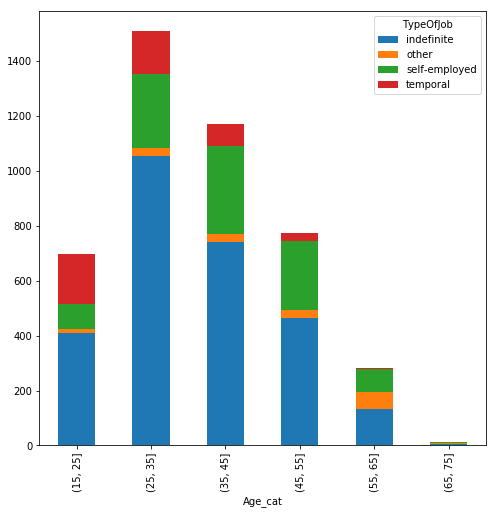

In [60]:
# basic stacked bar chart
TypeOfJob_Age.T.plot.bar(stacked=True, figsize=(8,8));  

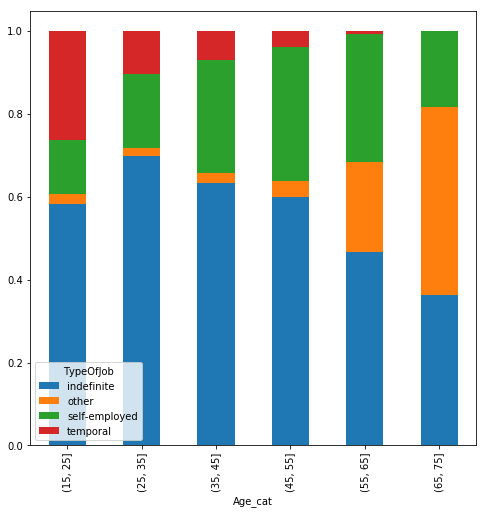

In [61]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").T.plot.bar(stacked=True, figsize=(8,8));

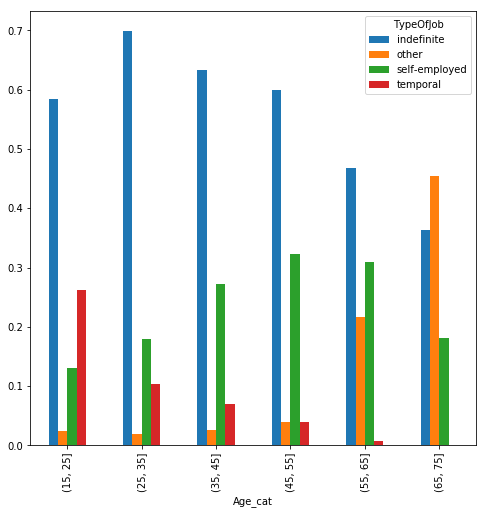

In [62]:
# grouped bar chart
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Age_cat,
            normalize="columns").T.plot.bar(figsize=(8,8));


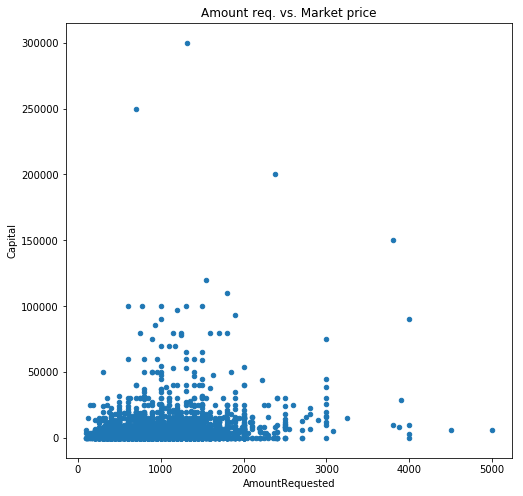

In [63]:
Credit_new.plot.scatter(y='Capital',
                        x='AmountRequested', 
                        figsize=(8,8),
                        title='Amount req. vs. Market price');

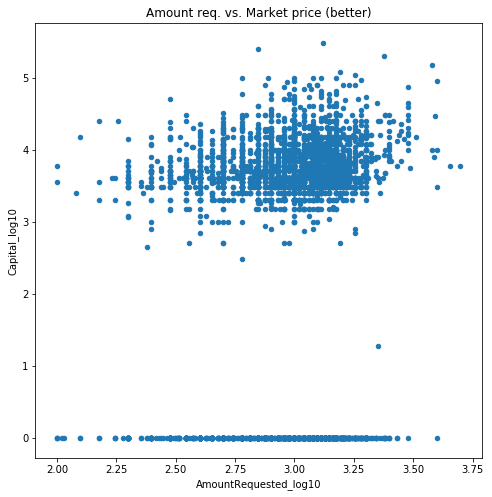

In [64]:
Credit_new['Capital_log10'] = (Credit_new.Capital+1).apply(np.log10)
Credit_new['AmountRequested_log10'] = (Credit_new.AmountRequested).apply(np.log10)
Credit_new.plot.scatter(y='Capital_log10',
                        x='AmountRequested_log10', 
                        figsize=(8,8),
                        title='Amount req. vs. Market price (better)');

 adding a center (dashed) and a regression line (blue)

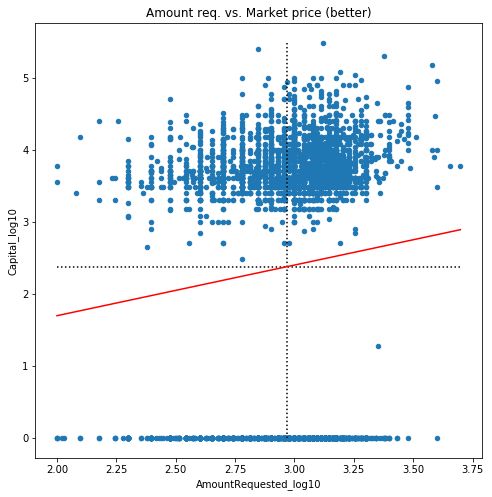

In [65]:

model = GLM.from_formula('Capital_log10 ~ AmountRequested_log10', Credit_new)
result = model.fit()

Credit_new.plot.scatter(y='Capital_log10',
                        x='AmountRequested_log10', 
                        figsize=(8,8))
plt.title('Amount req. vs. Market price (better)');
plt.plot([Credit_new.AmountRequested_log10.mean()]*2,
         [Credit_new.Capital_log10.min(),
          Credit_new.Capital_log10.max()],
         'k:');
plt.plot([Credit_new.AmountRequested_log10.min(),
          Credit_new.AmountRequested_log10.max()],
         [Credit_new.Capital_log10.mean()]*2,
         'k:');
plt.plot(np.linspace(Credit_new.AmountRequested_log10.min(), 
                     Credit_new.AmountRequested_log10.max(),
                     num=30),
         result.params.Intercept+
         result.params.AmountRequested_log10*
         np.linspace(Credit_new.AmountRequested_log10.min(),                                                             
                     Credit_new.AmountRequested_log10.max(),num=30),'r');


 (note that log10(x+1)=0 for x=0, so our transformation keeps the zeros)
     
 On the other hand, these same zeros spoil the regression: perhaps it would be more sensible to do the regression without them

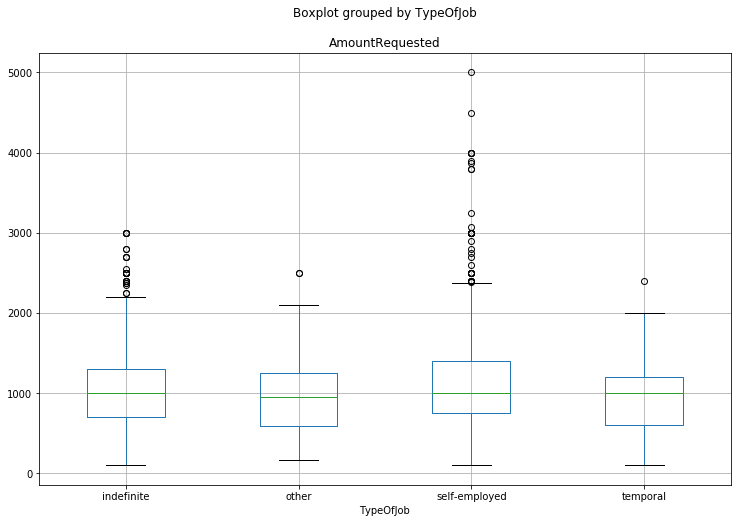

In [66]:
Credit_new.boxplot(column='AmountRequested',
                   by='TypeOfJob',
                   figsize=(12,8));

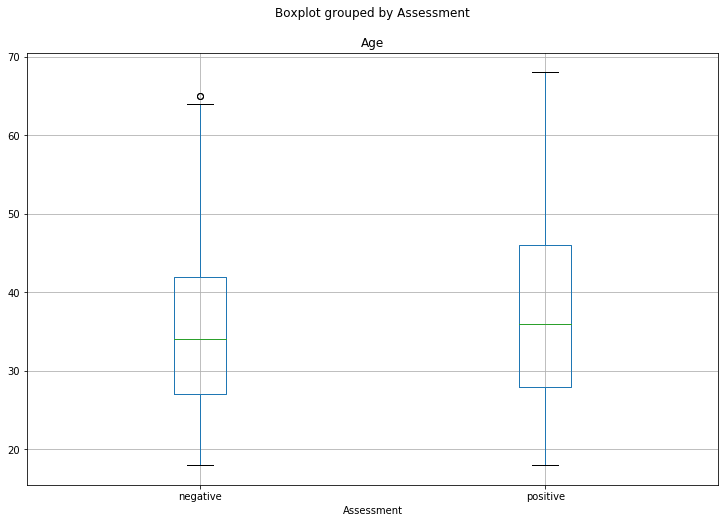

In [67]:
Credit_new.boxplot(column='Age',
                   by='Assessment',
                   figsize=(12,8));

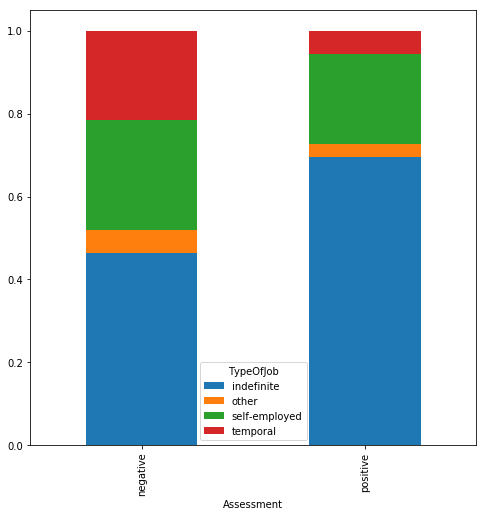

In [68]:
pd.crosstab(Credit_new.TypeOfJob, 
            Credit_new.Assessment,
            normalize="columns").T.plot.bar(stacked=True, 
                                            figsize=(8,8));

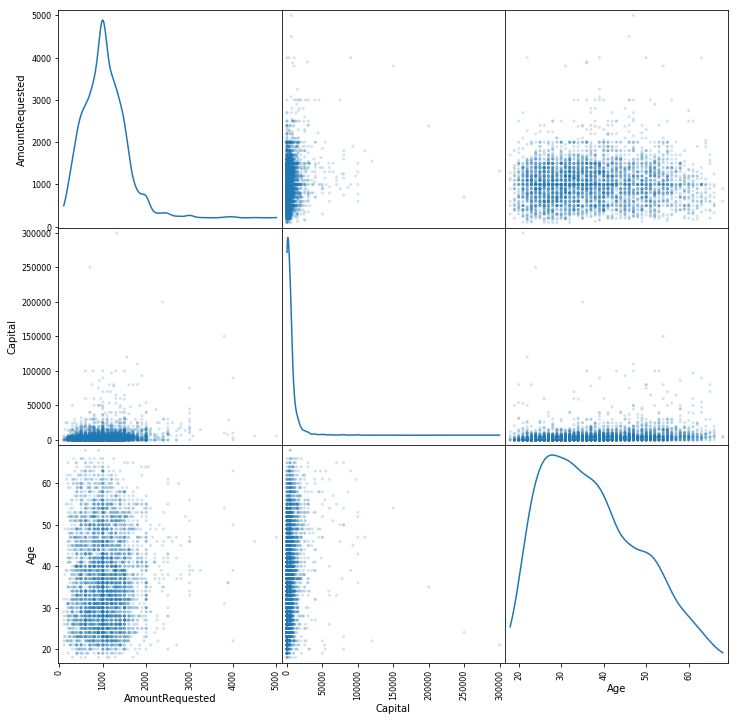

In [69]:
scatter_matrix(Credit_new.loc[:,['AmountRequested','Capital','Age']], 
               alpha=0.2, figsize=(12, 12), 
               diagonal='kde', marker='.');

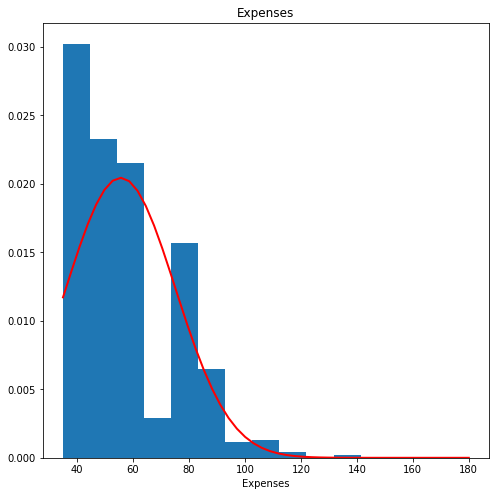

In [70]:
sigma=  Credit_new.Expenses.std()
mu=  Credit_new.Expenses.mean()
fig, ax = plt.subplots(figsize=(8,8))
count, bins, ignored = plt.hist(Credit_new.Expenses, 15, density=True)
dbins = np.linspace(bins[0], bins[-1])
plt.title("Expenses")
ax.set_xlabel("Expenses")
plt.plot(dbins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (dbins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r');

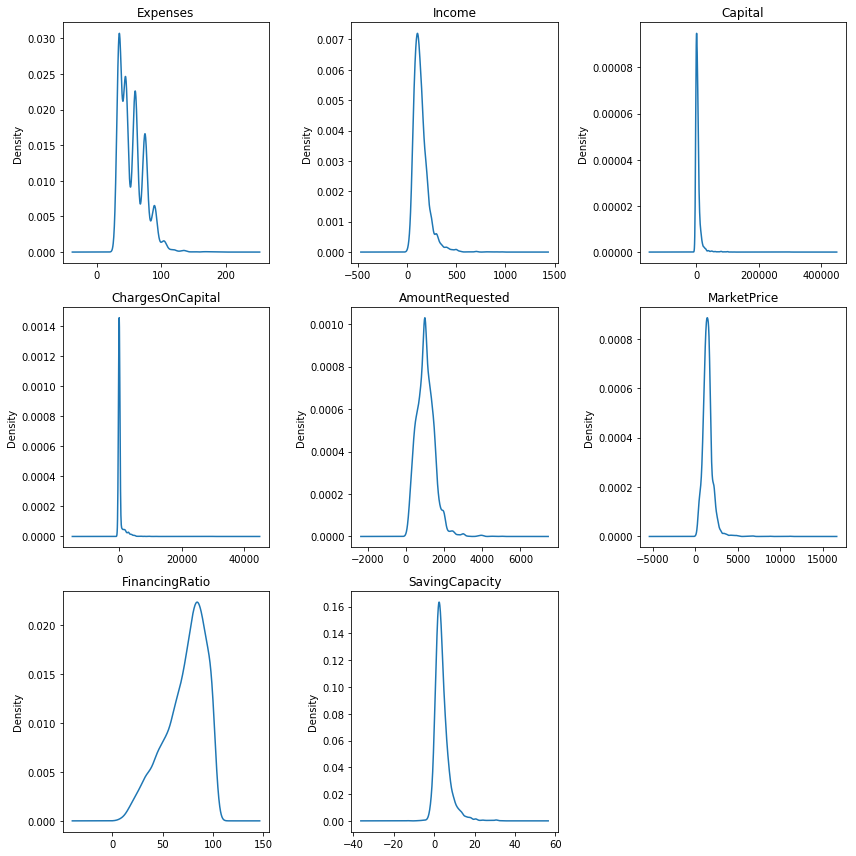

In [71]:
fig = plt.figure(figsize=(12,12))
for i in range(8):
    ax = fig.add_subplot(3, 3, i+1)
    Credit_new[Credit.columns[i+8]].plot.kde()
    plt.title(Credit.columns[i+8])
fig.tight_layout();

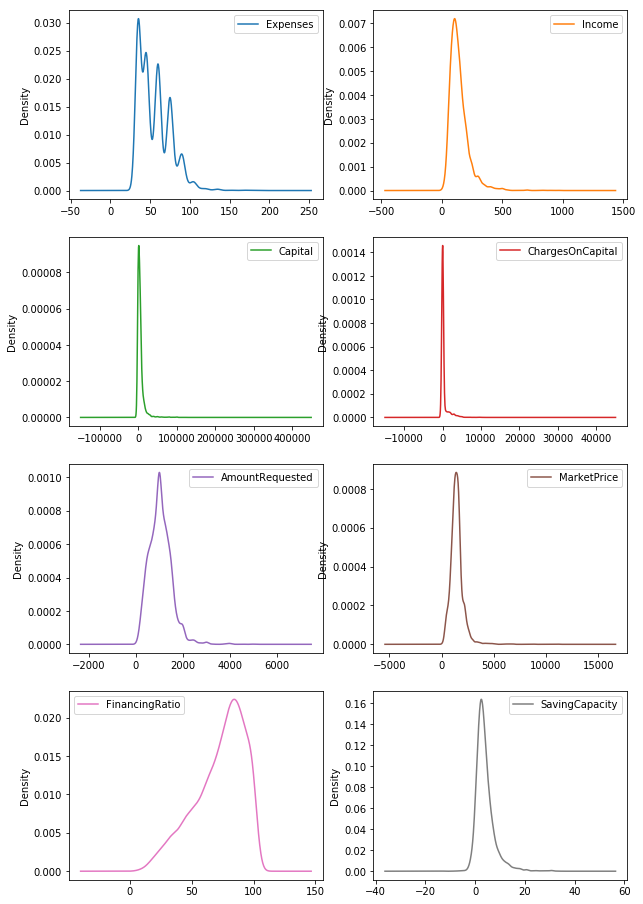

In [72]:
Credit_new.loc[:,'Expenses':'SavingCapacity'].plot.kde(subplots=True,
                                                       layout=(4,2),
                                                       sharex=False, 
                                                       figsize=(10,16));

 do any of the continuous variables "look" Gaussian? 
 features to look for in comparing to a Gaussian: outliers, asymmetries, long tails

 A useful tool for "Gaussianization" is the Box-Cox power transformation

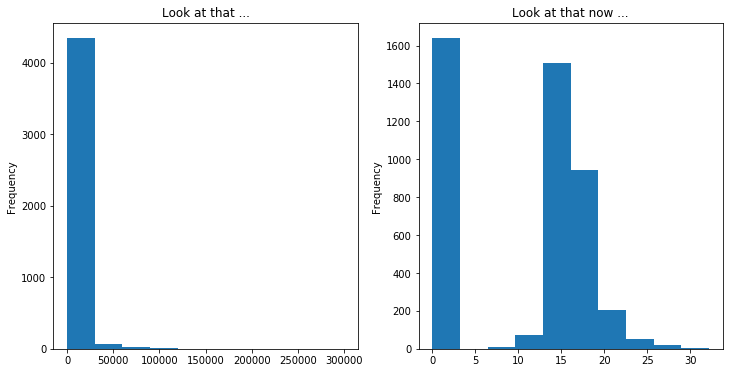

In [73]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1, 2, 1)
Credit_new.Capital.plot.hist(title='Look at that ...')

# the boxcox function transforms the data using 
# the power transformation (x**lambda -1)/ lambda
# the function takes care of finding the optimal lambda
x, _= boxcox(Credit_new.Capital+1)

Credit_new['Capital_BC'] = x
ax = fig.add_subplot(1, 2, 2)
Credit_new.Capital_BC.plot.hist(title='Look at that now ...');

## SECTION 8: ENDING THE PREPROCESSING

  
 Shuffle the data (to avoid possible ordering biases)

In [74]:
np.random.seed(144)
Credit_new = Credit_new.sample(frac=1).reset_index(drop=True)

 
 Save the preprocessed data into a file for future use
<div class="alert alert-block alert-warning">
Pandas allows to save the data in a lot of different formats as you can see [here](http://pandas-docs.github.io/pandas-docs-travis/io.html) among others CSV, pickle, HDF5, JSON, Excel as well as other data storages like SQL databases, Google Big Query, parquet or feather.

The simplest way is to save the data as a csv with `to_csv` or as a pickle file (native python store format) with `to_pickle`, this last one allows also to compress the data.
</div>


In [75]:
Credit_new.to_pickle('Credsco-processed.pkl.bz2',compression='bz2')

In [76]:
Credit_load =pd.read_pickle('Credsco-processed.pkl.bz2',compression='bz2')
Credit_load.head()

,Assessment,YearsInJob,Housing,Deadline,Age,MaritalStatus,Records,TypeOfJob,Expenses,Income,...,AmountRequested,MarketPrice,FinancingRatio,SavingCapacity,Dubious,Age_cat,Age2_cat,Capital_log10,AmountRequested_log10,Capital_BC
0,negative,5,other,60,33,single,no,indefinite,35,57.0,...,1000,1415,70.671,1.320,No,"(25, 35]",under55,0.000,3.000,0.000
1,positive,5,owner,48,43,married,no,self-employed,45,145.0,...,680,1350,50.370,7.059,No,"(35, 45]",under55,3.699,2.833,15.660
2,negative,2,parents,36,21,single,no,self-employed,35,221.0,...,500,650,76.923,13.392,No,"(15, 25]",under55,0.000,2.699,0.000
3,positive,7,owner,36,33,married,no,indefinite,45,208.0,...,500,1288,38.820,11.736,No,"(25, 35]",under55,3.602,2.699,14.989
4,negative,8,rent,60,25,married,yes,indefinite,73,280.0,...,600,1364,43.988,20.700,No,"(15, 25]",under55,0.000,2.778,0.000
